<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 10/asgnmt10')

In [0]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
from cutout import *
import torch
from torchsummary import summary
from resnet import ResNet18

from LR_Finder import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy

In [3]:
transform_params = dict()
transform_params['train'] = transforms.Compose([
                                       transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(),  
                                       transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),  
                                       transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
                                       transforms.ToTensor(),
                                       Cutout(n_holes=1, length=16,prob = 0.5),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

transform_params['test'] = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader,testloader = cifar_data_loader(transform_params,BatchSize=250)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet18().to(device)
summary(net, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,


Learning rate search finished. See the graph with {finder_name}.plot()


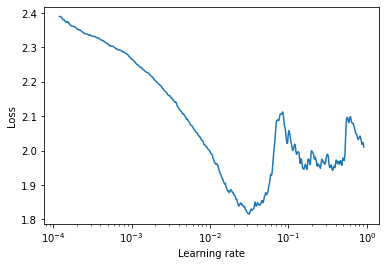

In [5]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

lr_finder = LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, end_lr=1, num_iter=500,step_mode="exp")
lr_finder.plot()

In [6]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.021, momentum=0.9,weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

for epoch in range(50):
    print("EPOCH:", epoch)
    tt.train_(net, device, trainloader, optimizer, criterion, epoch,L1 = False)
    acc = tt.test_(net, device, testloader)  
    scheduler.step(tt.test_losses[epoch])
       
print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.2839469909667969 Batch_id=199 Accuracy=43.45: 100%|██████████| 200/200 [00:39<00:00,  5.06it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -3.1885, Accuracy: 5445/10000 (54.45%)

EPOCH: 1


Loss=1.1147621870040894 Batch_id=199 Accuracy=54.71: 100%|██████████| 200/200 [00:39<00:00,  5.08it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.3216, Accuracy: 6302/10000 (63.02%)

EPOCH: 2


Loss=0.988295316696167 Batch_id=199 Accuracy=60.47: 100%|██████████| 200/200 [00:39<00:00,  5.07it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.5788, Accuracy: 6430/10000 (64.30%)

EPOCH: 3


Loss=0.8534464836120605 Batch_id=199 Accuracy=65.78: 100%|██████████| 200/200 [00:39<00:00,  5.01it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.2332, Accuracy: 7280/10000 (72.80%)

EPOCH: 4


Loss=0.8346284031867981 Batch_id=199 Accuracy=69.19: 100%|██████████| 200/200 [00:39<00:00,  5.06it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.0876, Accuracy: 7528/10000 (75.28%)

EPOCH: 5


Loss=0.7221913933753967 Batch_id=199 Accuracy=72.03: 100%|██████████| 200/200 [00:39<00:00,  5.02it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.4647, Accuracy: 7800/10000 (78.00%)

EPOCH: 6


Loss=0.7659945487976074 Batch_id=199 Accuracy=74.24: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.3430, Accuracy: 7519/10000 (75.19%)

EPOCH: 7


Loss=0.6495874524116516 Batch_id=199 Accuracy=75.80: 100%|██████████| 200/200 [00:40<00:00,  4.99it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.9638, Accuracy: 7981/10000 (79.81%)

EPOCH: 8


Loss=0.6370058655738831 Batch_id=199 Accuracy=77.45: 100%|██████████| 200/200 [00:39<00:00,  5.06it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.5946, Accuracy: 8095/10000 (80.95%)

EPOCH: 9


Loss=0.5857402682304382 Batch_id=199 Accuracy=78.69: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.9388, Accuracy: 8083/10000 (80.83%)

EPOCH: 10


Loss=0.6422693729400635 Batch_id=199 Accuracy=79.66: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.9860, Accuracy: 8378/10000 (83.78%)

EPOCH: 11


Loss=0.5275775194168091 Batch_id=199 Accuracy=80.73: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.3039, Accuracy: 8392/10000 (83.92%)

EPOCH: 12


Loss=0.500827968120575 Batch_id=199 Accuracy=81.66: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6639, Accuracy: 8450/10000 (84.50%)

EPOCH: 13


Loss=0.47715049982070923 Batch_id=199 Accuracy=82.43: 100%|██████████| 200/200 [00:39<00:00,  5.12it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.3243, Accuracy: 8476/10000 (84.76%)

EPOCH: 14


Loss=0.47294390201568604 Batch_id=199 Accuracy=83.02: 100%|██████████| 200/200 [00:38<00:00,  5.15it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6594, Accuracy: 8506/10000 (85.06%)

EPOCH: 15


Loss=0.4540455937385559 Batch_id=199 Accuracy=83.56: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0347, Accuracy: 8367/10000 (83.67%)

EPOCH: 16


Loss=0.48374468088150024 Batch_id=199 Accuracy=84.20: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.9728, Accuracy: 8632/10000 (86.32%)

EPOCH: 17


Loss=0.3917926847934723 Batch_id=199 Accuracy=84.67: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1509, Accuracy: 8594/10000 (85.94%)

EPOCH: 18


Loss=0.44279393553733826 Batch_id=199 Accuracy=85.22: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4149, Accuracy: 8535/10000 (85.35%)

EPOCH: 19


Loss=0.42658963799476624 Batch_id=199 Accuracy=85.52: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4071, Accuracy: 8707/10000 (87.07%)

EPOCH: 20


Loss=0.43100273609161377 Batch_id=199 Accuracy=85.84: 100%|██████████| 200/200 [00:39<00:00,  5.12it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3368, Accuracy: 8591/10000 (85.91%)

EPOCH: 21


Loss=0.4125983417034149 Batch_id=199 Accuracy=86.26: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.9073, Accuracy: 8750/10000 (87.50%)

EPOCH: 22


Loss=0.44919949769973755 Batch_id=199 Accuracy=86.55: 100%|██████████| 200/200 [00:38<00:00,  5.15it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.6579, Accuracy: 8805/10000 (88.05%)

EPOCH: 23


Loss=0.4121633470058441 Batch_id=199 Accuracy=87.15: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.0920, Accuracy: 8744/10000 (87.44%)

EPOCH: 24


Loss=0.3935072124004364 Batch_id=199 Accuracy=87.69: 100%|██████████| 200/200 [00:38<00:00,  5.15it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2279, Accuracy: 8814/10000 (88.14%)

EPOCH: 25


Loss=0.3658249080181122 Batch_id=199 Accuracy=87.60: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.1838, Accuracy: 8701/10000 (87.01%)

EPOCH: 26


Loss=0.38802772760391235 Batch_id=199 Accuracy=88.48: 100%|██████████| 200/200 [00:38<00:00,  5.15it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2293, Accuracy: 8904/10000 (89.04%)

EPOCH: 27


Loss=0.24718669056892395 Batch_id=199 Accuracy=88.48: 100%|██████████| 200/200 [00:38<00:00,  5.19it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.1430, Accuracy: 8903/10000 (89.03%)

EPOCH: 28


Loss=0.3127880394458771 Batch_id=199 Accuracy=88.54: 100%|██████████| 200/200 [00:38<00:00,  5.15it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2419, Accuracy: 8774/10000 (87.74%)

EPOCH: 29


Loss=0.2614421248435974 Batch_id=199 Accuracy=88.99: 100%|██████████| 200/200 [00:38<00:00,  5.19it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.4273, Accuracy: 8872/10000 (88.72%)

EPOCH: 30


Loss=0.2966427505016327 Batch_id=199 Accuracy=89.31: 100%|██████████| 200/200 [00:38<00:00,  5.18it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.3246, Accuracy: 8882/10000 (88.82%)

EPOCH: 31


Loss=0.2791573107242584 Batch_id=199 Accuracy=89.42: 100%|██████████| 200/200 [00:38<00:00,  5.18it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2544, Accuracy: 8812/10000 (88.12%)

EPOCH: 32


Loss=0.39671674370765686 Batch_id=199 Accuracy=89.47: 100%|██████████| 200/200 [00:38<00:00,  5.17it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.4613, Accuracy: 8938/10000 (89.38%)

EPOCH: 33


Loss=0.3194446861743927 Batch_id=199 Accuracy=89.79: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.1967, Accuracy: 8918/10000 (89.18%)

EPOCH: 34


Loss=0.3030891418457031 Batch_id=199 Accuracy=90.12: 100%|██████████| 200/200 [00:38<00:00,  5.19it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2159, Accuracy: 8852/10000 (88.52%)

EPOCH: 35


Loss=0.22693052887916565 Batch_id=199 Accuracy=90.30: 100%|██████████| 200/200 [00:38<00:00,  5.19it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.7657, Accuracy: 8959/10000 (89.59%)

EPOCH: 36


Loss=0.3316452205181122 Batch_id=199 Accuracy=90.49: 100%|██████████| 200/200 [00:38<00:00,  5.18it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.7732, Accuracy: 8855/10000 (88.55%)

EPOCH: 37


Loss=0.2646498382091522 Batch_id=199 Accuracy=90.76: 100%|██████████| 200/200 [00:38<00:00,  5.20it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.4746, Accuracy: 8876/10000 (88.76%)

EPOCH: 38


Loss=0.2881135940551758 Batch_id=199 Accuracy=90.65: 100%|██████████| 200/200 [00:38<00:00,  5.21it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.3869, Accuracy: 8934/10000 (89.34%)

EPOCH: 39


Loss=0.27803659439086914 Batch_id=199 Accuracy=91.13: 100%|██████████| 200/200 [00:38<00:00,  5.22it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.6221, Accuracy: 9009/10000 (90.09%)

EPOCH: 40


Loss=0.26082608103752136 Batch_id=199 Accuracy=90.98: 100%|██████████| 200/200 [00:38<00:00,  5.21it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.6302, Accuracy: 8960/10000 (89.60%)

EPOCH: 41


Loss=0.24173817038536072 Batch_id=199 Accuracy=91.53: 100%|██████████| 200/200 [00:38<00:00,  5.22it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.6053, Accuracy: 8936/10000 (89.36%)

EPOCH: 42


Loss=0.2532241642475128 Batch_id=199 Accuracy=91.35: 100%|██████████| 200/200 [00:38<00:00,  5.22it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.8156, Accuracy: 9034/10000 (90.34%)

EPOCH: 43


Loss=0.2450237274169922 Batch_id=199 Accuracy=91.48: 100%|██████████| 200/200 [00:38<00:00,  5.19it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.4407, Accuracy: 8922/10000 (89.22%)

EPOCH: 44


Loss=0.24110396206378937 Batch_id=199 Accuracy=91.78: 100%|██████████| 200/200 [00:38<00:00,  5.21it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.8436, Accuracy: 9025/10000 (90.25%)

EPOCH: 45


Loss=0.29386886954307556 Batch_id=199 Accuracy=92.09: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.6639, Accuracy: 9042/10000 (90.42%)

EPOCH: 46


Loss=0.213351771235466 Batch_id=199 Accuracy=92.03: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.6745, Accuracy: 9048/10000 (90.48%)

EPOCH: 47


Loss=0.27639254927635193 Batch_id=199 Accuracy=92.28: 100%|██████████| 200/200 [00:38<00:00,  5.18it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.5921, Accuracy: 8910/10000 (89.10%)

EPOCH: 48


Loss=0.2422010749578476 Batch_id=199 Accuracy=92.53: 100%|██████████| 200/200 [00:39<00:00,  5.12it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.7786, Accuracy: 8914/10000 (89.14%)

EPOCH: 49


Loss=0.21744652092456818 Batch_id=199 Accuracy=92.48: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s]



Test set: Average loss: -10.6572, Accuracy: 8905/10000 (89.05%)

Finished Training


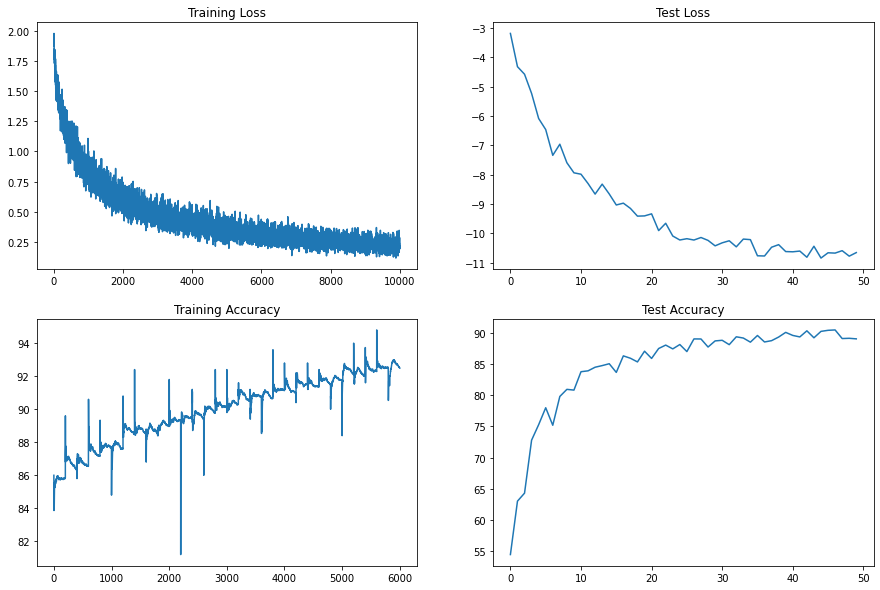

In [7]:
PlotTrainingGraphs(tt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

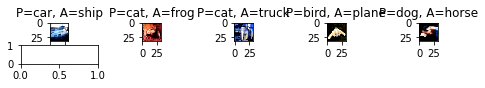

In [8]:
Misclassification(testloader,net,classes,device)

In [0]:
from gradcam import GradCamDisplay
import PIL
img_name =['airplane.png','automobile.png','bird.png','cat.png','deer.png']

pil_image = []
for i,img in enumerate(img_name):
   pil_image.append(PIL.Image.open(img))

In [0]:
from pylab import *
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4],padding=1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
images[:4]